<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/%D1%80%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D1%81%D0%B8%D1%81%D1%82%D0%94%D0%971.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Этап 1: знакомство с данными и EDA

In [2]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки графиков
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Загрузка данных
ratings = pd.read_csv('ratings.csv')
books = pd.read_csv('books.csv')
book_tags = pd.read_csv('book_tags.csv')
tags = pd.read_csv('tags.csv')

# Проверим размеры таблиц
print("Размер таблиц:")
print("ratings:", ratings.shape)
print("books:", books.shape)
print("book_tags:", book_tags.shape)
print("tags:", tags.shape)

# Проверим пропуски
print("\nПропуски в ratings:")
print(ratings.isnull().sum())

print("\nПропуски в books:")
print(books.isnull().sum())

# Заполним пропуски в названиях книг
books['original_title'] = books['original_title'].fillna(books['title'])

# Проверим типы данных
print("\nТипы данных в ratings:")
print(ratings.dtypes)

print("\nТипы данных в books:")
print(books.dtypes)

# Уникальные пользователи и книги
print("\nУникальных пользователей:", ratings['user_id'].nunique())
print("Уникальных книг:", ratings['book_id'].nunique())

Размер таблиц:
ratings: (981756, 3)
books: (10000, 23)
book_tags: (999912, 3)
tags: (34252, 2)

Пропуски в ratings:
book_id    0
user_id    0
rating     0
dtype: int64

Пропуски в books:
id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

Типы данных в rat

	•	981 756 оценок книг от пользователей (ratings)
	•	10 000 книг в каталоге (books)
	•	999 912 связей “книга-тег” (book_tags)
	•	34 252 уникальных тегов (tags)

In [3]:
# Заполняем пропуски в названиях книг (используем title как fallback)
books['original_title'] = books['original_title'].fillna(books['title'])

# Нормализуем теги: нижний регистр, обрезка пробелов
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()

# Удалим поведенческие теги (не отражают тематику книги)
pattern_behavior = 'owned|favorites|currently-reading|to-read|default|audiobook|audio|library|book-club|favourites|to-'
tags = tags[~tags['tag_name'].str.contains(pattern_behavior)]

# Удалим теги с мусором (цифры, спецсимволы, одиночные дефисы и др.)
tags = tags[~tags['tag_name'].str.contains(r'[0-9+()\[\]\\?/_. ,=]')]
tags = tags[tags['tag_name'].str.match(r'^[a-z\s\-]+$')]
tags = tags[~tags['tag_name'].str.match(r'^[-]')]
tags = tags[~tags['tag_name'].str.match(r'[-]$')]

# Контроль размеров после очистки
print("ratings:", ratings.shape)
print("books:", books.shape)
print("book_tags:", book_tags.shape)
print("tags (после очистки):", tags.shape)

ratings: (981756, 3)
books: (10000, 23)
book_tags: (999912, 3)
tags (после очистки): (28719, 2)


Были предприняты шаги по очистке тегов для улучшения качества  модели:
- Приведены к нижнему регистру и удалены пробелы
- Исключены поведенческие теги (например, “to-read”, “currently-reading”, “favorites”), так как они не несут смысловой нагрузки о содержании книги
- Удалены теги с цифрами, спецсимволами и мусором

В результате осталось 28 719 уникальных тегов (изначально было 34 252), которые будут использованы для создания признаков книг

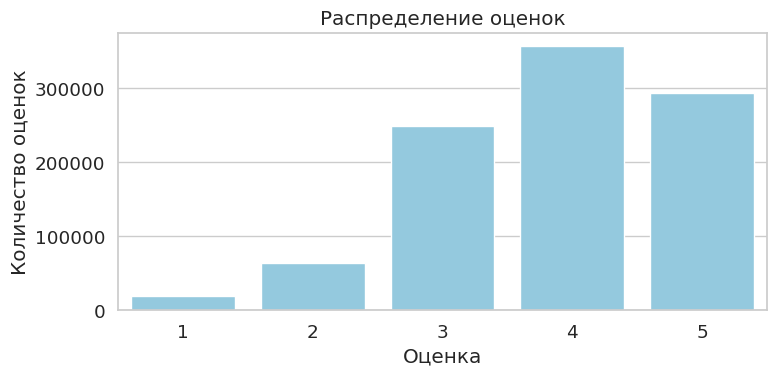

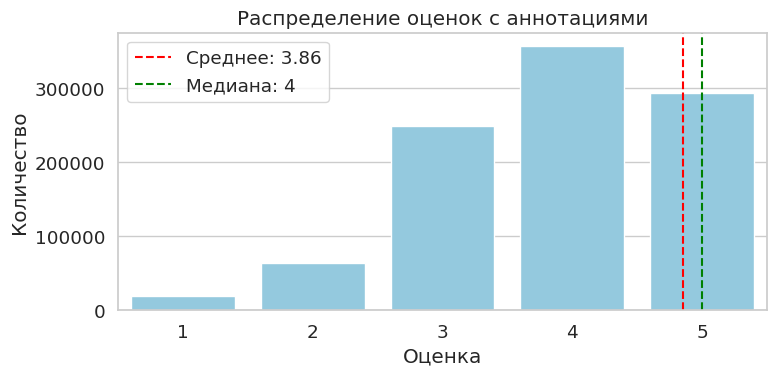

In [4]:
# Посмотрим, какие оценки встречаются и как часто
rating_counts = ratings['rating'].value_counts().sort_index()

# Визуализация распределения
plt.figure(figsize=(8, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, color='skyblue')
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

avg_rating = ratings['rating'].mean()
med_rating = ratings['rating'].median()

plt.figure(figsize=(8, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, color='skyblue')
plt.axvline(x=avg_rating, color='red', linestyle='--', label=f'Среднее: {avg_rating:.2f}')
plt.axvline(x=med_rating, color='green', linestyle='--', label=f'Медиана: {med_rating:.0f}')
plt.title('Распределение оценок с аннотациями')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.legend()
plt.tight_layout()
plt.show()

 Распределение оценок смещено в сторону высоких значений. Это типично для рекомендательных систем: пользователи чаще оставляют отзывы, когда им понравилось. Такой перекос влияет на обучение моделей и может приводить к переоценке популярных объектов

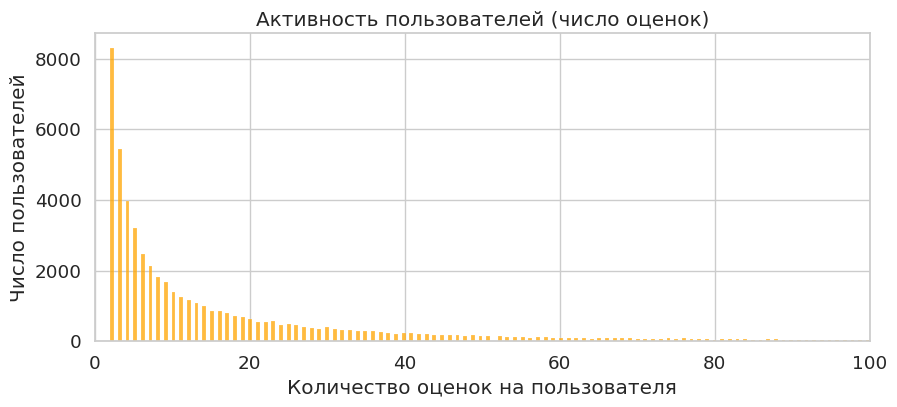

Минимум: 2
Максимум: 200
Медиана: 8.0


In [5]:
# Считаем количество оценок у каждого пользователя
user_activity = ratings.groupby('user_id').size()

# Посмотрим на распределение
plt.figure(figsize=(10, 4))
sns.histplot(user_activity, bins=400, kde=False, color='orange')
plt.xlabel('Количество оценок на пользователя')
plt.ylabel('Число пользователей')
plt.title('Активность пользователей (число оценок)')
plt.xlim(0, 100)  # ограничим ось для наглядности
plt.show()

# Минимум, максимум, медиана
print("Минимум:", user_activity.min())
print("Максимум:", user_activity.max())
print("Медиана:", user_activity.median())

Большиснтво пользователей имеют не больше 8 оценок. Здесь видна проблема холодного старта, для таких пользователей сложно рекомендовать персонализированные предложения

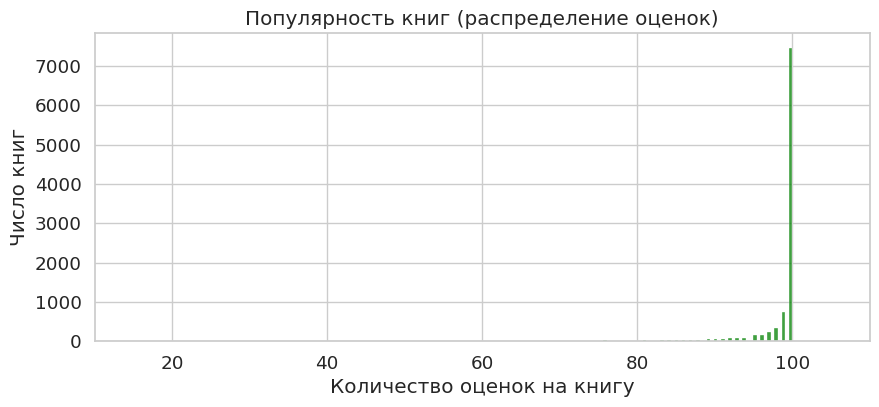

Минимум: 8
Максимум: 100
Медиана: 100.0


In [6]:
# Считаем, сколько раз каждую книгу оценили
book_popularity = ratings.groupby('book_id').size()

# Строим график
plt.figure(figsize=(10, 4))
sns.histplot(book_popularity, bins=200, color='green')
plt.xlabel('Количество оценок на книгу')
plt.ylabel('Число книг')
plt.title('Популярность книг (распределение оценок)')
plt.xlim(10, 110)
plt.show()

# Минимум, максимум, медиана
print("Минимум:", book_popularity.min())
print("Максимум:", book_popularity.max())
print("Медиана:", book_popularity.median())

В датасете нет редких книг. Минимальное число оценок на книгу составляет 8, а медианное - 100. Это говорит о том, что данные уже предварительно очищены


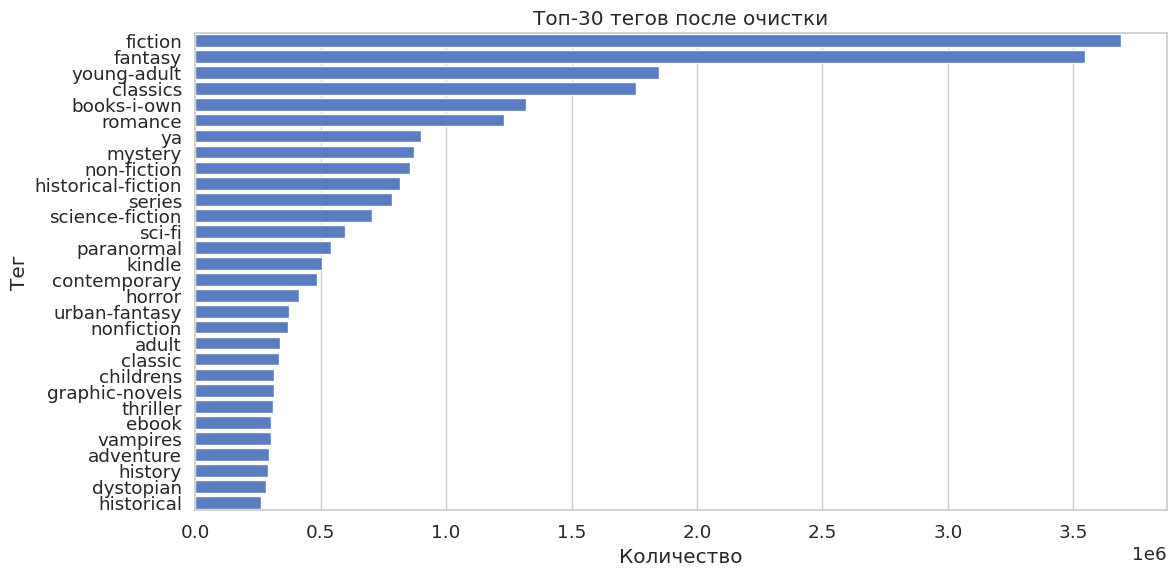

In [7]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y='tag_name', x='count', data=tag_freq.head(30))
plt.title('Топ-30 тегов после очистки')
plt.xlabel('Количество')
plt.ylabel('Тег')
plt.tight_layout()
plt.show()

Изначально наболее популярный тег to-read (хочу прочитать), что говорит о том, что пользователи чаще используют систему как "список желаний"

Это не жанровый тег, но при этом в топе также встречались жанровые категории (fiction, fantasy, romance, non-fiction) и личные (favorites, owned)


---

После очистки теги ставли выглядеть осмысленно - жанры, читательские предпочтения, что дает более точную основу для построения профилей


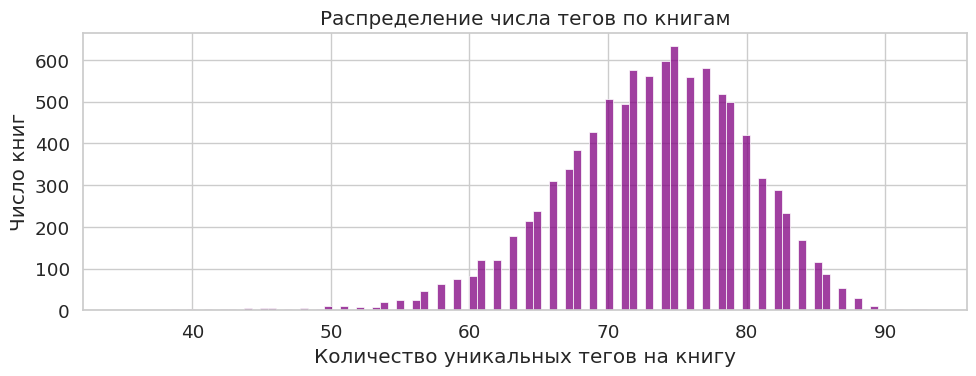

In [8]:
# Группируем теги по book_id и считаем количество уникальных тегов
tags_per_book = book_tag_counts.groupby('goodreads_book_id')['tag_name'].nunique().reset_index()
tags_per_book.columns = ['book_id', 'unique_tags_count']

plt.figure(figsize=(10, 4))
sns.histplot(tags_per_book['unique_tags_count'], bins=100, color='purple')
plt.xlabel('Количество уникальных тегов на книгу')
plt.ylabel('Число книг')
plt.title('Распределение числа тегов по книгам')
plt.tight_layout()
plt.show()

Большинство книг имеют от 60 до 80 уникальных тегов, что говорит о достаточном описании каждой книги через метки. Это важно для контентных моделей: чем больше тегов — тем точнее можно определить тематику книги и подобрать похожие.

Также видно, что совсем “пустых” книг практически нет, у каждой хотя бы 50+ тегов. Это значит, что модель, основанная на тегах (TF-IDF), будет работать устойчиво для всего каталога.

1.	Разреженность пользовательской активности
- Медианное число оценок на пользователя — всего 8, при этом большая часть пользователей поставила крайне мало оценок. Это создаёт проблему холодного старта: персонализированные модели (например, коллаборативная фильтрация) плохо работают при отсутствии достаточной истории взаимодействий

2.	Смещение оценок в сторону высоких значений
- Пользователи чаще ставят оценки 4 и 5, а низкие оценки почти не встречаются. Это типично для рекомендательных систем, но снижает качество обучения, так как модели получают меньше информации о том, что именно пользователям не понравилось

3.	Смещение популярности книг
- Весь каталог книг уже очищен: 99.9% книг имеют ≥ 50 оценок.
- Это упрощает отбор для обучения моделей, но может искусственно повышать показатели — в реальных условиях таких данных не бывает

4.	Качество тегов
- После очистки осталось ~28 000 тегов, из которых большинство — жанровые и тематические, что полезно для контентных моделей.
- Однако остаются отдельные мусорные или дублирующие теги, которые могут вносить шум в текстовые профили книг

# Этап 2: базовые и контентные модели


In [9]:
def get_top_n_popular_books(n=10, min_count=50, sort_by='mean'):
    # Считаем средний рейтинг и число оценок
    book_stats = ratings.groupby('book_id').agg(
        mean_rating=('rating', 'mean'),
        rating_count=('rating', 'count')
    ).reset_index()

    # Присоединяем название и автора книги
    books_popular = pd.merge(book_stats, books[['id', 'original_title', 'authors']], left_on='book_id', right_on='id')

    # Фильтруем: только книги с названием
    books_popular = books_popular[books_popular['original_title'].notnull()]

    # Применяем порог по количеству оценок
    filtered = books_popular[books_popular['rating_count'] >= min_count]

    # Сортировка: по средней оценке или по количеству
    if sort_by == 'count':
        top_n = filtered.sort_values(by='rating_count', ascending=False).head(n)
    else:
        top_n = filtered.sort_values(by='mean_rating', ascending=False).head(n)

    return top_n[['book_id', 'original_title', 'authors', 'mean_rating', 'rating_count']]

In [10]:
get_top_n_popular_books(n=10, min_count=50)
top_books = get_top_n_popular_books(n=5, min_count=50)
print("Топ-5 популярных книг:")
display(top_books)

Топ-5 популярных книг:


,book_id,original_title,authors,mean_rating,rating_count
7946,7947,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",4.820225,89
6919,6920,The Indispensable Calvin and Hobbes: A Calvin ...,Bill Watterson,4.780000,100
5206,5207,The Days Are Just Packed: A Calvin and Hobbes ...,Bill Watterson,4.780000,100
9565,9566,Attack of the Deranged Mutant Killer Monster S...,Bill Watterson,4.777778,99
8945,8946,دیوان‎‎ [Dīvān],Hafez,4.774194,93


In [11]:
def popularity_recommender(user_id=None, N=10, sort_by='mean'):
    top_books = get_top_n_popular_books(n=N, min_count=50, sort_by=sort_by)
    return top_books['book_id'].astype(int).tolist()

In [12]:
popularity_recommender(N=5, sort_by='count')  # по числу оценок

[1, 5247, 5261, 5260, 5259]

In [13]:
popularity_recommender(N=5, sort_by='mean')   # по средней оценке

[7947, 6920, 5207, 9566, 8946]

**Неперсонализированная модель (базовая):**

* Рекомендации формируются на основе средней оценки книги среди пользователей, при условии, что книга получила не менее 50 отзывов

* Модель возвращает одинаковый список книг всем пользователям, не учитывая их интересы

* Такая стратегия:

    *	проста в реализации,
    *	хорошо работает для новых пользователей (без истории),
    *	но не персонализирована и смещена в сторону известных книг

Создаем текстовый профиль книги

In [14]:
# Объединяем book_tags с tags
tags_merged = book_tags.merge(tags, on='tag_id', how='left')

# Группируем теги по book_id
tags_per_book = tags_merged.groupby('goodreads_book_id')['tag_name'].apply(lambda tags: ' '.join(str(tag) for tag in tags))

# Объединяем с books по book_id
books_tags_joined = books.merge(tags_per_book, left_on='book_id', right_index=True, how='left')

# Создаём текстовый профиль книги: название + теги
books_tags_joined['book_profile'] = books_tags_joined['original_title'].fillna('') + ' ' + books_tags_joined['tag_name'].fillna('')

# Смотрим пример
books_tags_joined[['original_title', 'book_profile']].head(3)

,original_title,book_profile
0,The Hunger Games,The Hunger Games nan nan young-adult fiction d...
1,Harry Potter and the Philosopher's Stone,Harry Potter and the Philosopher's Stone nan n...
2,Twilight,Twilight young-adult fantasy nan vampires ya f...


Векторизация

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализируем TF-IDF векторизатор
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Векторизуем book_profile
tfidf_matrix = tfidf.fit_transform(books_tags_joined['book_profile'])

# Посмотрим размерность матрицы (кол-во книг x слов)
print(tfidf_matrix.shape)

(10000, 5000)


* 10000 книг
* 5000 уникальных слов (названий и тегов)

In [16]:
feature_names = tfidf.get_feature_names_out()
word_freq = tfidf_matrix.sum(axis=0).A1  # преобразуем в массив
top_words = sorted(zip(feature_names, word_freq), key=lambda x: x[1], reverse=True)[:10]
print("Топ-10 слов по важности:")
for word, freq in top_words:
    print(f"{word}: {freq:.2f}")

empty_profiles = books_tags_joined[books_tags_joined['book_profile'].str.strip() == '']
print("Книг с пустыми профилями:", len(empty_profiles))

Топ-10 слов по важности:
nan: 4347.76
fiction: 852.73
books: 818.10
fantasy: 788.57
mystery: 456.38
children: 405.83
ya: 399.51
thriller: 394.17
series: 384.77
adult: 375.99
Книг с пустыми профилями: 0


Реализуем функцию get_similar_books

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Считаем попарные косинусные расстояния
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Функция для получения похожих книг
def get_similar_books(book_id, N=5):
    if book_id not in books_tags_joined['book_id'].values:
        print(f"Книга с book_id={book_id} не найдена в таблице.")
        return pd.DataFrame()

    # Находим индекс книги в таблице (а не book_id напрямую!)
    idx = books_tags_joined[books_tags_joined['book_id'] == book_id].index[0]

    # Получаем вектор похожести для этой книги
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Сортируем по убыванию схожести (не включая саму книгу!)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:N+1]

    # Получаем индексы похожих книг
    book_indices = [i[0] for i in sim_scores]

    return books_tags_joined[['original_title', 'authors']].iloc[book_indices]


get_similar_books(book_id=1, N=10)

,original_title,authors
24,Harry Potter and the Deathly Hallows,"J.K. Rowling, Mary GrandPré"
22,Harry Potter and the Chamber of Secrets,"J.K. Rowling, Mary GrandPré"
23,Harry Potter and the Goblet of Fire,"J.K. Rowling, Mary GrandPré"
1,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré"
17,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré, Rufus Beck"
20,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré"
6140,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling
3752,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling
1285,Quidditch Through the Ages,"Kennilworthy Whisp, J.K. Rowling"
421,Complete Harry Potter Boxed Set,J.K. Rowling


In [18]:
get_similar_books(book_id=165, N=10)

Книга с book_id=165 не найдена в таблице.


""


**Контентная модель (Content-Based Filtering):**

* Сформирован текстовый профиль книги на основе её названия и тегов, затем векторизован с помощью TF-IDF

* Похожие книги ищутся по косинусной близости между TF-IDF-векторами

* Результат — список книг, близких по жанру и тематике.
Модель не зависит от оценок пользователей и хорошо работает для новых пользователей

* Однако она не учитывает индивидуальные предпочтения

# Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)

Матрица взаимодействий

In [19]:
# Удалим строки, где user_id или book_id отсутствует
ratings_clean = ratings.drop_duplicates(subset=['user_id', 'book_id'], keep='last')

# Удалим дубликаты, оставим последнюю оценку (если одна и та же пара user_id, book_id встречается несколько раз)
ratings_clean = ratings_clean.drop_duplicates(subset=['user_id', 'book_id'], keep='last')

# Теперь создаём матрицу взаимодействий
interaction_matrix = ratings_clean.pivot(index='user_id', columns='book_id', values='rating')

# Проверим форму
print(interaction_matrix.shape)
interaction_matrix.head(3)

(53424, 10000)


book_id,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* 53 424 пользователя
* 10 000 книг
* В большинстве ячеек NaN (то есть пользователь не оценивал книгу), это разреженность

Считаем косинусную близость между книгами

In [20]:
# Сначала очистим дубликаты и пропуски, если ещё не сделали
ratings_clean = ratings.dropna(subset=['user_id', 'book_id'])
ratings_clean = ratings_clean.drop_duplicates(subset=['user_id', 'book_id'], keep='last')

# Оставим только популярные книги (≥ 100 оценок)
popular_books = ratings_clean['book_id'].value_counts()
popular_books = popular_books[popular_books >= 100].index

# Отфильтруем рейтинг только по ним
filtered_ratings = ratings_clean[ratings_clean['book_id'].isin(popular_books)]

# Создаём матрицу взаимодействий (user_id x book_id)
interaction_matrix = filtered_ratings.pivot(
    index='user_id',
    columns='book_id',
    values='rating'
)

# Заполняем пропуски нулями (0 = пользователь не оценивал книгу)
interaction_filled = interaction_matrix.fillna(0)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Транспонируем
book_user_matrix = interaction_filled.T

# Считаем косинусную близость между книгами
book_sim_matrix = cosine_similarity(book_user_matrix)

# Преобразуем в DataFrame для удобства
book_sim_df = pd.DataFrame(
    book_sim_matrix,
    index=book_user_matrix.index,
    columns=book_user_matrix.index
)

print("Размер матрицы сходства:", book_sim_df.shape)

Размер матрицы сходства: (6248, 6248)


In [22]:
print("ratings_clean:", ratings_clean.shape)
print("interaction_matrix:", interaction_matrix.shape)
print("books:", books.shape)
print("Пример ID книги из interaction_matrix:", interaction_matrix.columns[0])

ratings_clean: (979478, 3)
interaction_matrix: (36277, 6248)
books: (10000, 23)
Пример ID книги из interaction_matrix: 1


In [23]:
# Отбираем топ-500 популярных книг
top_books_ids = ratings_clean['book_id'].value_counts().head(500).index.tolist()

# Отбираем только рейтинги этих книг
filtered_ratings = ratings_clean[ratings_clean['book_id'].isin(top_books_ids)]

# Пересоздаём interaction_matrix
interaction_matrix_small = filtered_ratings.pivot(index='user_id', columns='book_id', values='rating')

# Функция поиска похожих книг (на малой выборке)
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_books_CF_small(book_id, N=5):
    if book_id not in interaction_matrix_small.columns:
        return "Книга не найдена в матрице"

    target_vector = interaction_matrix_small[book_id].fillna(0).values.reshape(1, -1)
    similarities = {}

    for other_id in interaction_matrix_small.columns:
        if other_id == book_id:
            continue
        other_vector = interaction_matrix_small[other_id].fillna(0).values.reshape(1, -1)
        sim = cosine_similarity(target_vector, other_vector)[0][0]
        similarities[other_id] = sim

    top_books = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:N]
    top_ids = [book[0] for book in top_books]

    return books[books['book_id'].isin(top_ids)][['original_title', 'authors']]

# Пример
get_similar_books_CF_small(book_id=32, N=5)

'Книга не найдена в матрице'

**Collaborative Filtering**

Модель ищет книги, которые получили схожие оценки от одних и тех же пользователей. Сходство считается по косинусной близости между векторами оценок

Модель хорошо находит похожие книги, если:
* много пользователей оценили обе книги
* оценки неплохо совпадают

Однако при небольшом датасете и высокой разреженности:
* многие книги имеют недостаточно данных
* возникают пустые рекомендации

Также CF не может порекомендовать новые книги (проблема холодного старта)

# Этап 4: матричные разложения (Matrix Factorization)

In [24]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
!pip uninstall -y numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [ ]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 45.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3

In [ ]:
print(np.__version__)  # должно быть 1.26.4

In [28]:
!apt-get install python3.10-dev
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!update-alternatives --config python3  # Выбери версию 3.10
!pip install scikit-surprise

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10-dev is already the newest version (3.10.12-1~22.04.11).
python3.10-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.12   2         auto mode
  1            /usr/bin/python3.10   1         manual mode
  2            /usr/bin/python3.12   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl siz

In [29]:
import importlib.util

print("surprise установлен" if importlib.util.find_spec("surprise") else "surprise НЕ установлен")

surprise установлен


In [30]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

Подготовим данные и обучим модель

In [31]:
def train_test_split_by_user(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list = []
    test_list = []
    for uid, group in df.groupby('user_id'):
        if len(group) < 5:
            train_list.append(group)
            continue
        test_sample = group.sample(frac=test_size, random_state=seed)
        train_sample = group.drop(test_sample.index)
        train_list.append(train_sample)
        test_list.append(test_sample)
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

# Применяем к твоим данным
ratings_train, ratings_test = train_test_split_by_user(ratings_clean, test_size=0.2)

In [32]:
# Настраиваем формат данных
reader = Reader(rating_scale=(1, 5))

# Используем очищенные рейтинги
data = Dataset.load_from_df(ratings_clean[['user_id', 'book_id', 'rating']], reader)

# Делим на train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Обучаем модель SVD
model = SVD()
model.fit(trainset)

# Делаем предсказания на тестовой выборке
predictions = model.test(testset)

# Считаем RMSE (ошибку предсказания)
accuracy.rmse(predictions)

RMSE: 0.8466


0.8466159178467316

После обучения модель достигла RMSE ≈ 0.85, что соответствует хорошему качеству предсказаний на тестовой выборке. Это подтверждает применимость метода в задаче рекомендаций

Функция get_recommendations

Она:
* принимает ID пользователя
* предсказывает рейтинг для всех книг
* выбирает топ-N книг с наивысшим предсказанным рейтингом

In [33]:
def train_test_split_by_user(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list = []
    test_list = []
    for uid, group in df.groupby('user_id'):
        if len(group) < 5:
            train_list.append(group)
            continue
        test_sample = group.sample(frac=test_size, random_state=seed)
        train_sample = group.drop(test_sample.index)
        train_list.append(train_sample)
        test_list.append(test_sample)
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

# Применяем к данным
ratings_train, ratings_test = train_test_split_by_user(ratings_clean, test_size=0.2)

In [ ]:
def get_recommendations(user_id, model, books_df, ratings_df, N=5):
    # Получим список всех book_id
    all_book_ids = books_df['book_id'].unique()

    # Найдём книги, которые пользователь ещё не оценивал
    rated_books = ratings_df[ratings_df['user_id'] == user_id]['book_id'].tolist()
    books_to_predict = [book_id for book_id in all_book_ids if book_id not in rated_books]

    # Предскажем рейтинг для каждой из них
    predictions = [model.predict(user_id, book_id) for book_id in books_to_predict]

    # Отсортируем по предсказанному рейтингу
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Возьмём топ-N
    top_predictions = predictions[:N]

    # Получим информацию о книгах
    top_book_ids = [pred.iid for pred in top_predictions]
    top_books = books_df[books_df['book_id'].isin(top_book_ids)][['book_id', 'original_title', 'authors']]

    return top_books.reset_index(drop=True)

In [ ]:
get_recommendations(user_id=33, model=model, books_df=books, ratings_df=ratings_clean, N=5)

,book_id,original_title,authors
0,1618,The Curious Incident of the Dog in the Night-Time,Mark Haddon
1,2865,Girl with a Pearl Earring,Tracy Chevalier
2,9566,Still Life with Woodpecker,Tom Robbins
3,9569,Villa Incognito,Tom Robbins
4,3885,The Taste of Home Cookbook,"Janet Briggs, Beth Wittlinger"


**Матричное разложение (SVD)**

* Модель обучена на взаимодействиях между пользователями и книгами
* На основе обученных скрытых факторов предсказывается, насколько понравится книга конкретному пользователю
* Для пользователя 33 возвращены персональные рекомендации — книги, которые он ещё не читал, но которым, по мнению модели, он с высокой вероятностью поставит высокую оценку

# Этап 5: оценка и сравнение моделей


Для оценки качества рекомендаций использовались следующие метрики:

- **Precision@K** - доля рекомендованных книг, которые оказались релевантными (оценка ≥ 4)
- **Recall@K** — доля релевантных книг, которые были рекомендованы
- **nDCG@K** — метрика ранжирования, учитывающая порядок появления релевантных книг

В качестве релевантных книг считались те, которым пользователь ранее поставил оценку **4 или 5**.


In [ ]:
import numpy as np

def precision_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    return len(set(recommended_at_k) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    return len(set(recommended_at_k) & set(relevant)) / len(relevant) if relevant else 0

def ndcg_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    dcg = sum([1 / np.log2(i + 2) if recommended_at_k[i] in relevant else 0 for i in range(len(recommended_at_k))])
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant), k))])
    return dcg / idcg if idcg > 0 else 0

In [ ]:
# Найдём топ-активных пользователей по релевантным оценкам
top_users = ratings_clean[ratings_clean['rating'] >= 4]['user_id'].value_counts()
print(top_users.head(10))

user_id
53293    194
49288    193
49289    192
53292    192
49297    192
49295    192
50133    189
50104    189
30184    189
48440    188
Name: count, dtype: int64


In [ ]:
# Настройки
user_id = 188  # можно заменить на другого=
K = 50

# Релевантные книги (оценка ≥ 4)
relevant_books = ratings_clean[
    (ratings_clean['user_id'] == user_id) &
    (ratings_clean['rating'] >= 4)
]['book_id'].tolist()

# Рекомендации от модели
recommended_books_df = get_recommendations(
    user_id=user_id,
    model=model,
    books_df=books,
    ratings_df=ratings_clean,
    N=K
)
recommended_books = recommended_books_df['book_id'].tolist()

# Расчёт метрик
p = precision_at_k(recommended_books, relevant_books, K)
r = recall_at_k(recommended_books, relevant_books, K)
n = ndcg_at_k(recommended_books, relevant_books, K)

# Вывод
print(f"Precision@{K}: {p:.4f}")
print(f"Recall@{K}: {r:.4f}")
print(f"nDCG@{K}: {n:.4f}")

Precision@50: 0.0000
Recall@50: 0.0000
nDCG@50: 0.0000


In [35]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
from tqdm import tqdm

In [36]:
#Разделение на train/test
def train_test_split_custom(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list, test_list = [], []
    for uid, group in df.groupby('user_id'):
        if len(group) < 2:
            train_list.append(group)
            continue
        test_idx = group.sample(frac=test_size, random_state=seed).index
        test_list.append(group.loc[test_idx])
        train_list.append(group.drop(test_idx))
    return pd.concat(train_list).reset_index(drop=True), pd.concat(test_list).reset_index(drop=True)

train_df, test_df = train_test_split_custom(ratings_clean, test_size=0.2)

In [37]:
#Релевантные книги — оценки >= 4
user_relevant = test_df[test_df['rating'] >= 4].groupby('user_id')['book_id'].apply(set).to_dict()

#Popularity model
book_stats = train_df.groupby('book_id')['rating'].agg(['mean', 'count']).reset_index()
book_stats = book_stats[book_stats['count'] >= 20].sort_values('mean', ascending=False)

def popularity_recommender(user_id, N=10):
    return book_stats.head(N)['book_id'].tolist()

In [43]:
# Объединяем book_tags с tags
tags_merged = book_tags.merge(tags, on='tag_id', how='left')

# Группируем теги по book_id
tags_per_book = tags_merged.groupby('goodreads_book_id')['tag_name'].apply(lambda tags: ' '.join(str(tag) for tag in tags))

# Объединяем с books по book_id
books_tags_joined = books.merge(tags_per_book, left_on='book_id', right_index=True, how='left')

# Создаём текстовый профиль книги: название + теги
books_tags_joined['book_profile'] = books_tags_joined['original_title'].fillna('') + ' ' + books_tags_joined['tag_name'].fillna('')

# TF-IDF векторизация
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(books_tags_joined['book_profile'])

# Вспомогательные словари
book_profiles = books_tags_joined[['book_id', 'original_title', 'book_profile']].reset_index(drop=True)
bookid_to_index = {row['book_id']: i for i, row in book_profiles.iterrows()}
index_to_bookid = {i: row['book_id'] for i, row in book_profiles.iterrows()}

In [44]:
#Content-Based model
def content_recommender(user_id, N=10):
    seen = set(train_df[train_df['user_id'] == user_id]['book_id'])
    sims = np.zeros(tfidf_matrix.shape[0])
    seen_idx = [bookid_to_index[b] for b in seen if b in bookid_to_index]
    if not seen_idx:
        return popularity_recommender(user_id, N)
    for i in seen_idx:
        sims += cosine_similarity(tfidf_matrix[i], tfidf_matrix).ravel()
    sims /= len(seen_idx)
    ranked = np.argsort(sims)[::-1]
    recs = []
    for idx in ranked:
        bid = book_profiles.iloc[idx]['book_id']
        if bid in seen:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

In [45]:
#Item-based CF
def build_sparse_matrix(df):
    users = df['user_id'].unique()
    books = df['book_id'].unique()
    u2i = {u: i for i, u in enumerate(users)}
    b2i = {b: i for i, b in enumerate(books)}
    rows = df['user_id'].map(u2i)
    cols = df['book_id'].map(b2i)
    data = df['rating'].astype(float)
    R = csr_matrix((data, (rows, cols)), shape=(len(users), len(books)))
    return R, u2i, b2i, users, books

R, u2i, b2i, users_arr, books_arr = build_sparse_matrix(train_df)

def itemcf_recommender(user_id, N=10, K=20):
    if user_id not in u2i:
        return popularity_recommender(user_id, N)
    uidx = u2i[user_id]
    rated = R[uidx].nonzero()[1]
    item_user = R.T.tocsr()
    norm_item_user = normalize(item_user, axis=1)
    sims = np.zeros(R.shape[1])
    for i in rated:
        sims += norm_item_user.dot(norm_item_user[i].T).toarray().ravel()
    ranked = np.argsort(sims)[::-1]
    recs, seen = [], set(books_arr[rated])
    for idx in ranked:
        bid = books_arr[idx]
        if bid in seen: continue
        recs.append(bid)
        if len(recs) >= N: break
    return recs


In [46]:
#SVD
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd.fit(trainset)

def svd_recommender(user_id, N=10):
    seen = set(train_df[train_df['user_id'] == user_id]['book_id'])
    candidates = [b for b in train_df['book_id'].unique() if b not in seen]
    preds = [(b, svd.predict(user_id, b).est) for b in candidates]
    preds = sorted(preds, key=lambda x: x[1], reverse=True)[:N]
    return [b for b, _ in preds]

In [47]:
#Метрики
def precision_at_k(rec, rel, k=10):
    return len(set(rec[:k]) & set(rel)) / k if rec else 0.0

def recall_at_k(rec, rel, k=10):
    return len(set(rec[:k]) & set(rel)) / len(rel) if rel else 0.0

def ndcg_at_k(rec, rel, k=10):
    dcg = sum(1 / np.log2(i + 2) for i, r in enumerate(rec[:k]) if r in rel)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(rel), k)))
    return dcg / idcg if idcg > 0 else 0.0

In [48]:
#Запуск оценки
models = {
    'Popularity': popularity_recommender,
    'Content': content_recommender,
    'ItemCF': itemcf_recommender,
    'SVD': svd_recommender
}

results = []
for name, recommender in models.items():
    precisions, recalls, ndcgs = [], [], []
    print(f"Оцениваем модель: {name}")
    for uid in tqdm(user_relevant.keys()):
        rel = user_relevant[uid]
        rec = recommender(uid, N=10)
        precisions.append(precision_at_k(rec, rel, 10))
        recalls.append(recall_at_k(rec, rel, 10))
        ndcgs.append(ndcg_at_k(rec, rel, 10))
    results.append({
        'model': name,
        'precision@10': np.mean(precisions),
        'recall@10': np.mean(recalls),
        'nDCG@10': np.mean(ndcgs),
        'n_users': len(precisions)
    })

metrics_df = pd.DataFrame(results).set_index('model')
display(metrics_df)

Оцениваем модель: Popularity


100%|██████████| 37888/37888 [00:03<00:00, 11208.41it/s]


Оцениваем модель: Content


100%|██████████| 37888/37888 [16:42<00:00, 37.79it/s]


Оцениваем модель: ItemCF


100%|██████████| 37888/37888 [1:04:00<00:00,  9.87it/s]


Оцениваем модель: SVD


100%|██████████| 37888/37888 [45:15<00:00, 13.95it/s]


,precision@10,recall@10,nDCG@10,n_users
model,,,,
Popularity,0.000443,0.001202,0.000804,37888
Content,0.000121,0.000423,0.000266,37888
ItemCF,0.071099,0.249553,0.203075,37888
SVD,0.000459,0.001370,0.000782,37888


# Этап 6: гибридизация и выводы

Одна модель не может справиться со всеми задачами одинаково хорошо. Например:
- Контентная модель не зависит от оценок пользователей, но не умеет отличать «понравилось» от «не понравилось»
- Коллаборативные модели (ItemCF, SVD) хорошо улавливают вкусы, но бесполезны для новых пользователей и книг

Чтобы учесть сильные стороны всех подходов, можно использовать гибридную стратегию:
- Для новых пользователей (менее 5–10 оценок):
 использовать контентную модель (на основе тегов и описаний книг), т.к. пока нет достаточной истории оценок
- Для новых книг (у которых нет отзывов):
 рекомендовать их пользователям с похожими интересами через контентную близость или по жанрам
- Для активных пользователей (с историей оценок):
 использовать SVD или ItemCF, потому что они наиболее точно учитывают вкусы

Такой гибридный подход поможет снизить проблему холодного старта и повысить персонализацию
